# Estimating coefficients to the log-linear model

In [314]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import scipy as sp

from scipy.optimize import root, minimize, root_scalar, diagbroyden, least_squares, approx_fprime
import scipy.optimize as opt

In [219]:
x

array([0])

In [235]:
beta

array([[5],
       [3]])

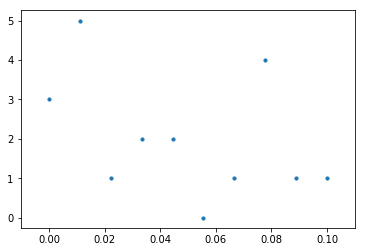

In [637]:
beta = np.array([1, 0.1]).reshape(2, -1)
x = np.linspace(0, 0.1, 10)
X = np.column_stack([np.ones(x.shape[0]), x])
y = stats.poisson.rvs(np.exp((X@beta)).reshape(-1))
plt.scatter(x, y, s=10)

### Define objective functions

In [779]:
def objective(beta):
    
    r = (X*(y.reshape(-1, 1)-np.exp(X@beta.reshape(-1, 1)))).mean(axis=0)
    
    return (r**2).mean()

def objective_boot(beta):
    
    beta = beta.reshape(-1, num_boot, order='F')
    
    momcond = np.einsum('nm,nk->nmk', x_mat, y_mat)
    
    momcond -= np.einsum('nm,nk->nmk', x_mat, np.exp(x_mat@beta))
    
#     weighted_momcond = np.einsum('ijk,ik->ijk', momcond, y_counts).mean(axis=0)
    return (momcond.mean(axis=0)**2).mean(axis=0)

def objective_boot_combined(beta):
    
    return objective_boot(beta).mean()

In [780]:
EPS = np.MachAr().eps

def _get_epsilon(x, s, epsilon, n):
    if epsilon is None:
        h = EPS**(1. / s) * np.maximum(np.abs(x), 0.1)
    else:
        if np.isscalar(epsilon):
            h = np.empty(n)
            h.fill(epsilon)
        else:  # pragma : no cover
            h = np.asarray(epsilon)
            if h.shape != x.shape:
                raise ValueError("If h is not a scalar it must have the same"
                                 " shape as x.")
    return h


def gradient(x, num_features=2, epsilon=None, args=(), kwargs={}):
    
    f_sep = objective_boot
    n = len(x)
    f0 = f_sep(*((x,)+args), **kwargs)
    dim = (1,)
    grad = np.zeros((n,) + dim, np.promote_types(float, x.dtype))
    epsilon = _get_epsilon(x, 2, None, n)
    ei = np.zeros((n,),float)
    
    for start in range(num_features):
        ei[start::num_features] = epsilon[start::num_features]
        res = ((f_sep(*((x+ei,) + args), **kwargs) - f0)/epsilon[start::num_features]).reshape(-1, 1)
        grad[start::num_features, :] = res
        ei[start::num_features] = 0.0
        
    grad = grad.squeeze().T
    return grad/(x.shape[0]/num_features)

In [906]:
N = 10
beta = np.array([1, 2]).reshape(2, -1)
x = np.random.choice(2, N)
X = np.column_stack([np.ones(x.shape[0]), x])
y = stats.poisson.rvs(np.exp((X@beta)).reshape(-1))
# sns.scatterplot(x, y, s=N, x_jitter=1, y_jitter=1)

x_mat = X
num_boot = 10000
y_mat = np.vstack([ stats.poisson.rvs(np.exp((X@beta)).reshape(-1)) for boot in range(num_boot)]).T
boot_init = np.hstack([beta for boot in range(num_boot)]).ravel()

In [907]:
print('fast gradient', gradient(boot_init)[:5])
# print('true gradient', opt.approx_fprime(boot_init, objective_boot_combined , 1e-10)[:5])

fast gradient [-0.00515969 -0.00437868 -0.00583619 -0.00493286 -0.00571176]


In [908]:
# %time a = minimize(objective_boot_combined, np.zeros(boot_init.shape), method='L-BFGS-B')

In [909]:
%time ls_sol, _, _, _ = np.linalg.lstsq(x_mat, np.log(y_mat+1), rcond=-1)

CPU times: user 7.64 ms, sys: 2.77 ms, total: 10.4 ms
Wall time: 4.08 ms


In [910]:
init = minimize(objective, [0, 0])
init_boot = np.concatenate([init.x for i in range(num_boot)])

In [911]:
%time b = minimize(objective_boot, ls_sol.reshape(-1, order='F'), jac=gradient, method='L-BFGS-B')

CPU times: user 6.77 s, sys: 153 ms, total: 6.92 s
Wall time: 1.75 s


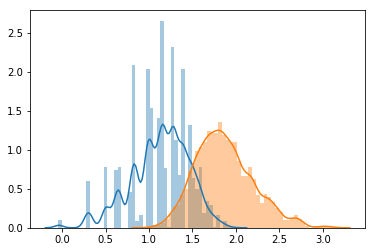

In [902]:
# sns.distplot(a.x.reshape(2, -1, order='F')[0, :])
sns.distplot(b.x.reshape(2, -1, order='F')[0, :])
sns.distplot(b.x.reshape(2, -1, order='F')[1, :])

In [232]:
%%time
root(objective, np.array([0, 0]))

TypeError: fsolve: there is a mismatch between the input and output shape of the 'func' argument 'objective'.Shape should be (2,) but it is (1,).

In [146]:
%%time
minimize(objective, np.array([0, 0]))

ValueError: setting an array element with a sequence.

In [109]:
objective(beta)

0.012903005403173375

In [118]:
beta_boot

array([5, 3, 5, 3])

In [110]:
mean_objective_boot(beta_boot)

array([0.01290301, 0.01290301])

In [53]:
objective(np.array([0, 5]))

array([-0.01202577, -4.17486046])